In [1]:
import torch
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2_video_predictor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
import os
import numpy as np
import cv2
import pickle
from tqdm import tqdm
import re

In [2]:
frame_dir = r"N:\Projekte\ZIM_Amaize-Q\14_Karsten_Analyse\20251203_M400_AlSi10Mg_Baum_Wand_Lattice\EOT\LPPF_TREE_NEW_CROP\EOT_JET"

In [3]:


checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

# predictor.reset_state(inference_state)
inference_state = predictor.init_state(video_path=frame_dir)

frame loading (JPEG): 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1242/1242 [00:49<00:00, 25.33it/s]


In [4]:

frame_names = [
    p for p in os.listdir(frame_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]

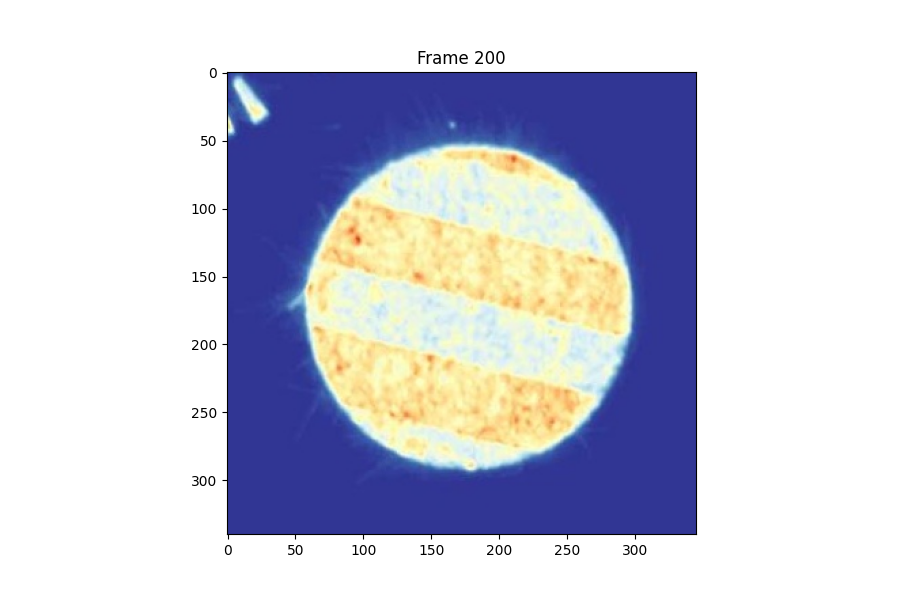

In [18]:
frame_idx = 200

img_path = os.path.join(frame_dir, frame_names[frame_idx])
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

pointlist = []

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        # Koordinaten in int runden, falls gewünscht:
        x = int(event.xdata)
        y = int(event.ydata)
        pointlist.append((x, y))
         # direkt sichtbar machen
        ax.scatter([x], [y], color='yellow', s=10, edgecolor='black')
        fig.canvas.draw_idle()

# wichtig für JupyterLab
%matplotlib widget

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.set_title(f"Frame {frame_idx}")
ax.imshow(img)

# Event registrieren
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()


In [ ]:
%matplotlib widget

In [ ]:
plt.close('all')

In [20]:
pointlist

[(189, 96),
 (185, 136),
 (162, 184),
 (152, 240),
 (140, 273),
 (207, 62),
 (18, 24),
 (1, 37)]

In [ ]:
#deactivate canvas frontend for normal plots
%matplotlib inline 

D:\fg-hybrid\PythonScripts\SAM2\sam2\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (D:\fg-hybrid\PythonScripts\SAM2\sam2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


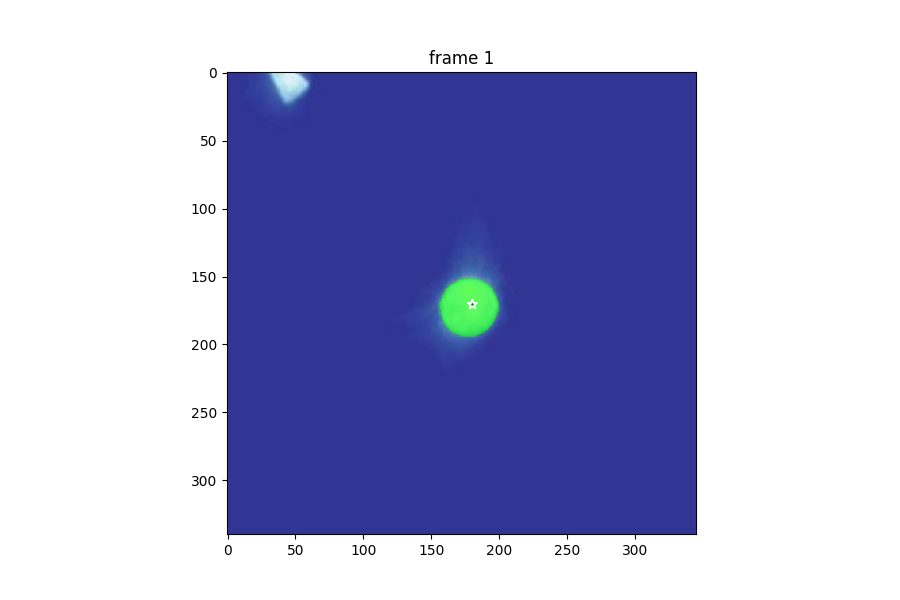

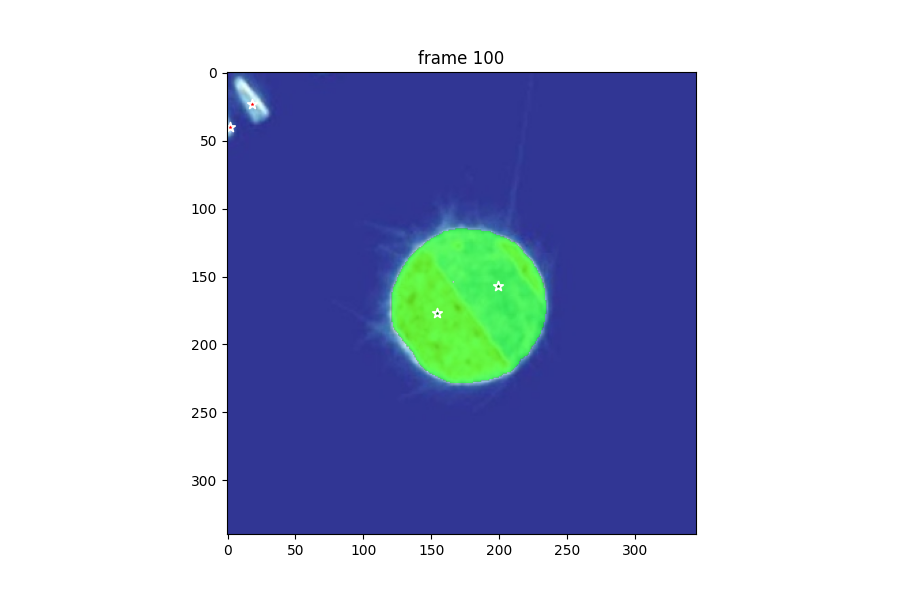

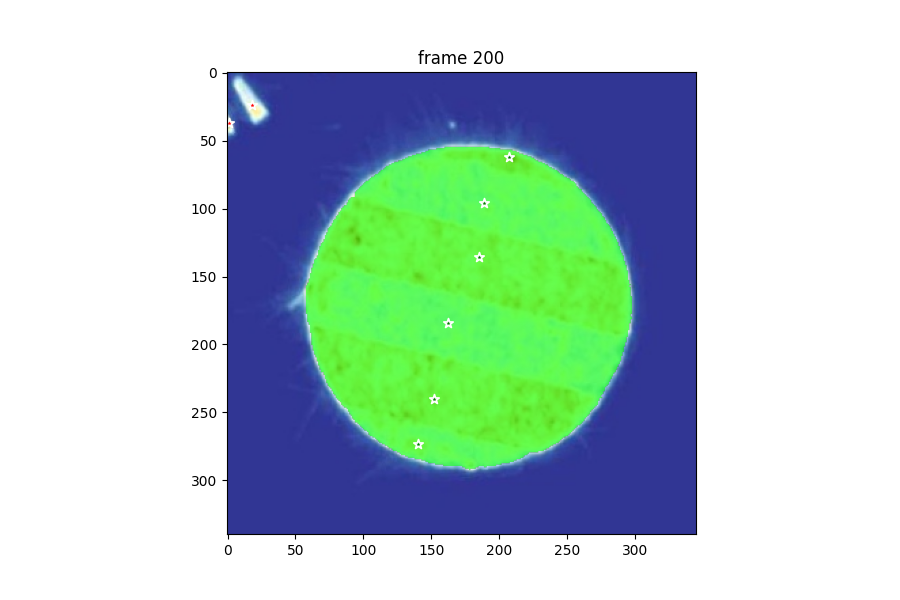

In [25]:

out_obj_ids, out_mask_logits = annotate_frame_interactive(
    "cylinder",
    0,
    np.array([
        (180, 170),
    ],
    dtype=np.float32),
    np.array([1,], dtype=np.int32), 
    frame_index=1,
    color="green"
)

out_obj_ids, out_mask_logits = annotate_frame_interactive(
    "cylinder",
    0,
    np.array([
        (154, 177), (199, 157),
        (18, 23), (2, 40)
    ],
    dtype=np.float32),
    np.array([1, 1, 0, 0], dtype=np.int32), 
    frame_index=100,
    color="green"
)


out_obj_ids, out_mask_logits = annotate_frame_interactive(
    "cylinder",
    0,
    np.array([
       (189, 96), (185, 136), (162, 184), (152, 240), (140, 273), (207, 62),
        (18, 24), (1, 37)
    ],
    dtype=np.float32),
    np.array([1, 1, 1, 1, 1, 1,
              0, 0
                     
    ],
    dtype=np.int32), 
    frame_index=200,
    color="green"
)



In [26]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

with open("pickle_files/LPBF_Karsten25_Tree.pkl", "wb") as f:
    pickle.dump(video_segments, f)

propagate in video: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [1:10:52<00:00,  3.43s/it]


# Validate

In [29]:
with open("pickle_files/LPBF_Karsten25_Tree.pkl", "rb") as f:
    video_segments = pickle.load(f)

In [32]:
print(len(frame_names))

1242


In [34]:
# feste Farben pro Klasse (BGR für OpenCV!)
CLASS_COLORS = {
    0: (0,   0, 255),   # Rot
    1: (0, 255,   0),   # Grün
    2: (255, 0,   0),   # Blau
    3: (0, 255, 255),   # Gelb
    4: (255, 0, 255),   # Magenta (falls weitere Klassen existieren)
    5: (255,255,  0),   # Cyan
}

for export_idx, frame_key in enumerate(tqdm(video_segments.keys(), desc="Processing frames")):

    sample_mask = next(iter(video_segments[frame_key].values()))
    h, w = sample_mask.shape[-2:]
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for cls_id, out_mask in video_segments[frame_key].items():
        if cls_id not in CLASS_COLORS:
            continue

        mask = out_mask.reshape(h, w)
        color_mask[mask] = CLASS_COLORS[cls_id]

    cv2.imwrite(
        f"frames/LPBF_TREE_MASK/{str(export_idx).zfill(4)}.tif",
        color_mask
    )



Processing frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1241/1241 [00:02<00:00, 492.75it/s]


# Helper functions

In [22]:
def annotate_frame(name, object_id, points, labels, frame_index=0, show_figure=True, color=None):
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=frame_index,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

    if show_figure:
        plt.figure(figsize=(9, 6))
        plt.title(f"frame {frame_index}")
        plt.imshow(Image.open(os.path.join(frame_dir, frame_names[frame_index])))
        show_points(points, labels, plt.gca())
        show_mask((out_mask_logits[object_id] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[object_id], color=color)

    return out_obj_ids, out_mask_logits

In [23]:
def annotate_frame_interactive(name, object_id, points, labels, frame_index=0, color=None):

    global pointlist
    pointlist = []
    
    #ursprüngliches SAM + Zeichnen ----
    out_obj_ids, out_mask_logits = annotate_frame(
        name=name,
        object_id=object_id,
        points=points,
        labels=labels,
        frame_index=frame_index,
        show_figure=True,
        color=color
    )

    # Das Fenster, das annotate_frame gerade erstellt hat
    fig = plt.gcf()
    ax = plt.gca()

    def onclick(event):
        if event.xdata is None or event.ydata is None:
            return

        x = int(event.xdata)
        y = int(event.ydata)
        pointlist.append((x, y))

        # direkt sichtbar machen
        ax.scatter([x], [y], color='yellow', s=10, edgecolor='black')
        fig.canvas.draw_idle()

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()
    return out_obj_ids, out_mask_logits

In [8]:
def preprocess(raw_dir, frame_dir):
    sorted_files = sorted(os.listdir(raw_dir), key=lambda f: int(f.split("_")[1]))
    len(sorted_files)
    count = 0;
    for f in sorted_files:
        img = cv2.imread(os.path.join(raw_dir, f))
        img_cropped = img[160:1400,:1400]
        #(218, 241), (702, 712)
        #img_cropped = img[241:712,218:702]
        cv2.imwrite(os.path.join(frame_dir, f"{count:04d}.jpg"), img_cropped)
        count += 1

def preprocess1(raw_dir, frame_dir):
    files = [
        f for f in os.listdir(raw_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))
    ]

    def sort_key(f):
        parts = f.split("_")
        if len(parts) > 1 and parts[1].isdigit():
            return int(parts[1])
        else:
            return -1   # Dateien ohne gültigen Index ganz nach vorne / hinten

    sorted_files = sorted(files, key=sort_key)

    os.makedirs(frame_dir, exist_ok=True)

    for count, f in enumerate(sorted_files):
        img = cv2.imread(os.path.join(raw_dir, f))
        if img is None:
            print(f"Warnung: konnte {f} nicht lesen")
            continue

        img_cropped = img[160:1400, :1400]
        cv2.imwrite(os.path.join(frame_dir, f"{count:04d}.jpg"), img_cropped)


def crop(raw_dir, out_dir):
    sorted_files = [f for f in sorted(os.listdir(raw_dir))
                    if f.lower().endswith((".jpg", ".png", ".tif", ".jpeg"))]

    count = 0;
    for count, f in enumerate(tqdm(sorted_files, desc="Cropping")):
        img = cv2.imread(os.path.join(raw_dir, f))
        #(218, 241), (702, 712) #old 
        #img_cropped = img[241:712,218:702] #cylinder
        img_cropped = img[241:712,218:702] #tree
        
        
        cv2.imwrite(os.path.join(out_dir, f"{count:04d}.jpg"), img_cropped)
        count += 1

     
raw_dir = r"N:\Projekte\ZIM_Amaize-Q\14_Karsten_Analyse\20251203_M400_AlSi10Mg_Baum_Wand_Lattice\EOT\Bilder\Crop_Gray"
frame_dir = r"N:\Projekte\ZIM_Amaize-Q\14_Karsten_Analyse\20251203_M400_AlSi10Mg_Baum_Wand_Lattice\EOT\Bilder\Crop_Gray_Zyl"

#preprocess("raw/01", frame_dir)
#preprocess1(raw_dir, frame_dir)
crop(raw_dir, frame_dir)


Cropping: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1243/1243 [00:40<00:00, 30.96it/s]


In [24]:
def show_mask(mask, ax, obj_id=None, color=None):
    color_map = {
        "red": np.concatenate([np.array([1.0, 0.0, 0.0]), np.array([0.6])], axis=0),
        "green": np.concatenate([np.array([0.0, 1.0, 0.0]), np.array([0.6])], axis=0),
        "blue": np.concatenate([np.array([0.0, 0.0, 1.0]), np.array([0.6])], axis=0),
    }
    
    if color is None:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = color_map[color]
        
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=50):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))